In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const

import Bell_EBM as ebm
import Bell_EBM.pretty_plotting

In [2]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense#, Flatten, MaxPooling2D, Conv2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
n_its = 100
a_arr = np.logspace(np.log10(0.02), np.log10(1), n_its, endpoint=True)
# tirr_arr = np.linspace(1000, 4000, n_its, endpoint=True)
# teff_arr = np.linspace()
# rstar_arr = np.linspace(0.1, 5, n_its, endpoint=True)
# vWind_arr = np.logspace(2, 4, n_its, endpoint=True)
# albedo_arr = np.linspace(0.1, 0.9, n_its, endpoint=True)

In [4]:
x = np.zeros((1,5))
y = np.zeros((1,512))

for i in range(n_its):
    planet = ebm.Planet('bell2018', rad=1.900*const.R_jup.value, mass=1.470*const.M_jup.value,
                        Porb=1.09142030, a=a_arr[i]*const.au.value, inc=83.37, vWind=5e3)
    star = ebm.Star(teff=6300., rad=1.59, mass=1.20)
    system = ebm.System(star, planet)
    
    # Run initial burn-in - try guessing the equilibrium temperature to begin with
    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*2
    dt = system.planet.Porb/1000.
    times, maps = system.run_model(T0, t0, t1, dt, verbose=False)
    
    x = np.append(x, np.array([planet.orbit.a/const.au.value*100, planet.wind_dlon*10000, star.teff/4000, star.rad/const.R_sun.value, planet.albedo])[np.newaxis,:], axis=0)
    y = np.append(y, maps.reshape(1,-1), axis=0)
    
x = x[1:]
y = y[1:]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [6]:
input_shape = (5,)
output_size = planet.map.values.size
output_shape = planet.map.values.shape

In [7]:
model = Sequential([
    Dense(100, activation='relu', input_shape=input_shape, kernel_initializer='glorot_normal'),
    Dense(200, activation='relu', kernel_initializer='glorot_normal'),
    Dense(300, activation='relu', kernel_initializer='glorot_normal'),
    Dense(400, activation='relu', kernel_initializer='glorot_normal'),
    Dense(output_size, activation='linear', kernel_initializer='glorot_normal')
])

In [8]:
optimizer = Adam(lr=1e-2, decay=1e-2)#, decay=1e-1)#lr=1e-5,decay=1e-5, clipnorm=5.)
model.compile(optimizer=optimizer,
              loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1,
                           mode='auto', restore_best_weights=True)]

In [9]:
history = model.fit(x_train, y_train, epochs=10000, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks, shuffle=True)

Train on 80 samples, validate on 20 samples
Epoch 1/10000
80/80 [==============================] - 0s 1ms/step - loss: 1461123.0250 - mean_absolute_error: 1043.9677 - val_loss: 1130800.3750 - val_mean_absolute_error: 820.2656
Epoch 2/10000
80/80 [==============================] - 0s 352us/step - loss: 1404814.1500 - mean_absolute_error: 941.7792 - val_loss: 1102237.1250 - val_mean_absolute_error: 838.4427
Epoch 3/10000
80/80 [==============================] - 0s 333us/step - loss: 1307875.3500 - mean_absolute_error: 929.0171 - val_loss: 1134967.3750 - val_mean_absolute_error: 846.2594
Epoch 4/10000
80/80 [==============================] - 0s 358us/step - loss: 1348497.2125 - mean_absolute_error: 961.7752 - val_loss: 1204599.0000 - val_mean_absolute_error: 914.5322
Epoch 5/10000
80/80 [==============================] - 0s 360us/step - loss: 1390416.7000 - mean_absolute_error: 1001.6942 - val_loss: 1200787.2500 - val_mean_absolute_error: 914.5900
Epoch 6/10000
80/80 [====================

80/80 [==============================] - 0s 472us/step - loss: 3420.0630 - mean_absolute_error: 39.3420 - val_loss: 2421.4832 - val_mean_absolute_error: 37.0011
Epoch 47/10000
80/80 [==============================] - 0s 708us/step - loss: 3264.9427 - mean_absolute_error: 38.9689 - val_loss: 2284.1570 - val_mean_absolute_error: 35.5630
Epoch 48/10000
80/80 [==============================] - 0s 640us/step - loss: 3442.3055 - mean_absolute_error: 38.5119 - val_loss: 2016.9375 - val_mean_absolute_error: 34.3856
Epoch 49/10000
80/80 [==============================] - 0s 601us/step - loss: 3572.7204 - mean_absolute_error: 40.8330 - val_loss: 2628.9966 - val_mean_absolute_error: 37.7264
Epoch 50/10000
80/80 [==============================] - 0s 462us/step - loss: 3078.9949 - mean_absolute_error: 38.5601 - val_loss: 1882.5922 - val_mean_absolute_error: 32.4535
Epoch 51/10000
80/80 [==============================] - 0s 506us/step - loss: 3276.1490 - mean_absolute_error: 38.1281 - val_loss: 2421

Epoch 93/10000
80/80 [==============================] - 0s 357us/step - loss: 1196.7600 - mean_absolute_error: 21.0117 - val_loss: 749.8168 - val_mean_absolute_error: 19.7737
Epoch 94/10000
80/80 [==============================] - 0s 324us/step - loss: 1188.9950 - mean_absolute_error: 21.0403 - val_loss: 781.2943 - val_mean_absolute_error: 19.4892
Epoch 95/10000
80/80 [==============================] - 0s 415us/step - loss: 1092.6065 - mean_absolute_error: 19.9044 - val_loss: 805.3597 - val_mean_absolute_error: 19.8165
Epoch 96/10000
80/80 [==============================] - 0s 355us/step - loss: 1088.5875 - mean_absolute_error: 19.9733 - val_loss: 736.7789 - val_mean_absolute_error: 19.2390
Epoch 97/10000
80/80 [==============================] - 0s 328us/step - loss: 1095.1669 - mean_absolute_error: 19.8952 - val_loss: 710.7333 - val_mean_absolute_error: 18.6620
Epoch 98/10000
80/80 [==============================] - 0s 340us/step - loss: 1075.0403 - mean_absolute_error: 19.6268 - val_

Epoch 140/10000
80/80 [==============================] - 0s 405us/step - loss: 752.4252 - mean_absolute_error: 16.0255 - val_loss: 572.2540 - val_mean_absolute_error: 15.9284
Epoch 141/10000
80/80 [==============================] - 0s 411us/step - loss: 752.5145 - mean_absolute_error: 16.2051 - val_loss: 620.8854 - val_mean_absolute_error: 16.5833
Epoch 142/10000
80/80 [==============================] - 0s 380us/step - loss: 747.2067 - mean_absolute_error: 16.2342 - val_loss: 545.7106 - val_mean_absolute_error: 15.7617
Epoch 143/10000
80/80 [==============================] - 0s 419us/step - loss: 741.9163 - mean_absolute_error: 16.0956 - val_loss: 576.7681 - val_mean_absolute_error: 16.0174
Epoch 144/10000
80/80 [==============================] - 0s 407us/step - loss: 724.3080 - mean_absolute_error: 15.8801 - val_loss: 542.9370 - val_mean_absolute_error: 15.5394
Epoch 145/10000
80/80 [==============================] - 0s 373us/step - loss: 718.9560 - mean_absolute_error: 15.7198 - val_

Epoch 187/10000
80/80 [==============================] - 0s 351us/step - loss: 552.1866 - mean_absolute_error: 13.5064 - val_loss: 428.1772 - val_mean_absolute_error: 13.1465
Epoch 188/10000
80/80 [==============================] - 0s 322us/step - loss: 546.6153 - mean_absolute_error: 13.3796 - val_loss: 400.5369 - val_mean_absolute_error: 12.7172
Epoch 189/10000
80/80 [==============================] - 0s 367us/step - loss: 557.7807 - mean_absolute_error: 13.4396 - val_loss: 409.6785 - val_mean_absolute_error: 12.9773
Epoch 190/10000
80/80 [==============================] - 0s 481us/step - loss: 546.2984 - mean_absolute_error: 13.3988 - val_loss: 437.5433 - val_mean_absolute_error: 13.3399
Epoch 191/10000
80/80 [==============================] - 0s 420us/step - loss: 537.7465 - mean_absolute_error: 13.2633 - val_loss: 402.5942 - val_mean_absolute_error: 13.0353
Epoch 192/10000
80/80 [==============================] - 0s 399us/step - loss: 541.6399 - mean_absolute_error: 13.3048 - val_

Epoch 234/10000
80/80 [==============================] - 0s 388us/step - loss: 440.7269 - mean_absolute_error: 12.0179 - val_loss: 297.1606 - val_mean_absolute_error: 10.8279
Epoch 235/10000
80/80 [==============================] - 0s 328us/step - loss: 436.5288 - mean_absolute_error: 11.9495 - val_loss: 304.1032 - val_mean_absolute_error: 10.9341
Epoch 236/10000
80/80 [==============================] - 0s 350us/step - loss: 433.5093 - mean_absolute_error: 11.9832 - val_loss: 300.1468 - val_mean_absolute_error: 10.7379
Epoch 237/10000
80/80 [==============================] - 0s 353us/step - loss: 427.1449 - mean_absolute_error: 11.8438 - val_loss: 285.7335 - val_mean_absolute_error: 10.8152
Epoch 238/10000
80/80 [==============================] - 0s 349us/step - loss: 428.6104 - mean_absolute_error: 11.8263 - val_loss: 295.3214 - val_mean_absolute_error: 10.8323
Epoch 239/10000
80/80 [==============================] - 0s 372us/step - loss: 425.5897 - mean_absolute_error: 11.8183 - val_

Epoch 281/10000
80/80 [==============================] - 0s 361us/step - loss: 350.2460 - mean_absolute_error: 10.6479 - val_loss: 229.4973 - val_mean_absolute_error: 9.3785
Epoch 282/10000
80/80 [==============================] - 0s 389us/step - loss: 345.1602 - mean_absolute_error: 10.5725 - val_loss: 233.9089 - val_mean_absolute_error: 9.3737
Epoch 283/10000
80/80 [==============================] - 0s 374us/step - loss: 344.0764 - mean_absolute_error: 10.5574 - val_loss: 229.8444 - val_mean_absolute_error: 9.3144
Epoch 284/10000
80/80 [==============================] - 0s 362us/step - loss: 343.9514 - mean_absolute_error: 10.5779 - val_loss: 222.9558 - val_mean_absolute_error: 9.1505
Epoch 285/10000
80/80 [==============================] - 0s 352us/step - loss: 343.9698 - mean_absolute_error: 10.5181 - val_loss: 211.8313 - val_mean_absolute_error: 9.0416
Epoch 286/10000
80/80 [==============================] - 0s 340us/step - loss: 353.1174 - mean_absolute_error: 10.5749 - val_loss:

80/80 [==============================] - 0s 356us/step - loss: 282.7382 - mean_absolute_error: 9.6254 - val_loss: 171.1902 - val_mean_absolute_error: 8.1872
Epoch 329/10000
80/80 [==============================] - 0s 361us/step - loss: 278.4346 - mean_absolute_error: 9.5394 - val_loss: 175.9535 - val_mean_absolute_error: 8.3334
Epoch 330/10000
80/80 [==============================] - 0s 366us/step - loss: 279.0695 - mean_absolute_error: 9.5299 - val_loss: 173.8220 - val_mean_absolute_error: 8.1471
Epoch 331/10000
80/80 [==============================] - 0s 345us/step - loss: 278.7192 - mean_absolute_error: 9.5524 - val_loss: 176.2658 - val_mean_absolute_error: 8.1834
Epoch 332/10000
80/80 [==============================] - 0s 370us/step - loss: 279.9319 - mean_absolute_error: 9.5578 - val_loss: 168.3571 - val_mean_absolute_error: 8.0768
Epoch 333/10000
80/80 [==============================] - 0s 372us/step - loss: 276.4166 - mean_absolute_error: 9.5429 - val_loss: 184.2958 - val_mean_a

80/80 [==============================] - 0s 436us/step - loss: 228.9702 - mean_absolute_error: 8.6870 - val_loss: 155.6952 - val_mean_absolute_error: 7.5376
Epoch 376/10000
80/80 [==============================] - 0s 359us/step - loss: 222.3827 - mean_absolute_error: 8.5510 - val_loss: 141.5293 - val_mean_absolute_error: 7.3770
Epoch 377/10000
80/80 [==============================] - 0s 350us/step - loss: 229.4939 - mean_absolute_error: 8.6002 - val_loss: 138.7655 - val_mean_absolute_error: 7.3134
Epoch 378/10000
80/80 [==============================] - 0s 327us/step - loss: 226.6455 - mean_absolute_error: 8.7267 - val_loss: 151.7750 - val_mean_absolute_error: 7.4669
Epoch 379/10000
80/80 [==============================] - 0s 347us/step - loss: 221.7678 - mean_absolute_error: 8.5572 - val_loss: 149.8128 - val_mean_absolute_error: 7.6237
Epoch 380/10000
80/80 [==============================] - 0s 353us/step - loss: 223.0856 - mean_absolute_error: 8.6197 - val_loss: 150.3922 - val_mean_a

80/80 [==============================] - 0s 371us/step - loss: 202.4617 - mean_absolute_error: 8.1564 - val_loss: 141.4390 - val_mean_absolute_error: 7.0633
Epoch 423/10000
80/80 [==============================] - 0s 498us/step - loss: 186.6269 - mean_absolute_error: 7.9735 - val_loss: 131.2195 - val_mean_absolute_error: 7.1885
Epoch 424/10000
80/80 [==============================] - 0s 438us/step - loss: 193.9859 - mean_absolute_error: 7.9804 - val_loss: 138.8367 - val_mean_absolute_error: 7.3745
Epoch 425/10000
80/80 [==============================] - 0s 476us/step - loss: 189.0318 - mean_absolute_error: 8.0848 - val_loss: 122.4872 - val_mean_absolute_error: 6.8996
Epoch 426/10000
80/80 [==============================] - 0s 448us/step - loss: 184.8852 - mean_absolute_error: 7.7905 - val_loss: 127.2338 - val_mean_absolute_error: 7.0118
Epoch 427/10000
80/80 [==============================] - 0s 454us/step - loss: 183.6110 - mean_absolute_error: 7.7803 - val_loss: 136.0658 - val_mean_a

80/80 [==============================] - 0s 767us/step - loss: 156.0194 - mean_absolute_error: 7.3151 - val_loss: 120.2265 - val_mean_absolute_error: 6.7104
Epoch 470/10000
80/80 [==============================] - 0s 538us/step - loss: 156.4732 - mean_absolute_error: 7.2703 - val_loss: 117.2088 - val_mean_absolute_error: 6.6436
Epoch 471/10000
80/80 [==============================] - 0s 385us/step - loss: 157.5111 - mean_absolute_error: 7.3677 - val_loss: 119.7685 - val_mean_absolute_error: 6.7140
Epoch 472/10000
80/80 [==============================] - 0s 375us/step - loss: 158.3985 - mean_absolute_error: 7.4031 - val_loss: 126.2152 - val_mean_absolute_error: 6.8791
Epoch 473/10000
80/80 [==============================] - 0s 652us/step - loss: 156.7944 - mean_absolute_error: 7.3750 - val_loss: 118.7512 - val_mean_absolute_error: 6.7172
Epoch 474/10000
80/80 [==============================] - 0s 446us/step - loss: 156.0350 - mean_absolute_error: 7.2508 - val_loss: 119.5575 - val_mean_a

80/80 [==============================] - 0s 406us/step - loss: 134.8705 - mean_absolute_error: 6.8170 - val_loss: 109.3280 - val_mean_absolute_error: 6.3462
Epoch 517/10000
80/80 [==============================] - 0s 348us/step - loss: 137.4455 - mean_absolute_error: 6.8374 - val_loss: 114.6874 - val_mean_absolute_error: 6.4996
Epoch 518/10000
80/80 [==============================] - 0s 357us/step - loss: 144.0262 - mean_absolute_error: 7.2190 - val_loss: 125.8458 - val_mean_absolute_error: 6.5893
Epoch 519/10000
80/80 [==============================] - 0s 333us/step - loss: 137.2478 - mean_absolute_error: 7.0296 - val_loss: 123.4486 - val_mean_absolute_error: 6.7968
Epoch 520/10000
80/80 [==============================] - 0s 382us/step - loss: 136.8812 - mean_absolute_error: 6.9454 - val_loss: 124.1133 - val_mean_absolute_error: 6.7592
Epoch 521/10000
80/80 [==============================] - 0s 382us/step - loss: 140.0950 - mean_absolute_error: 7.3263 - val_loss: 112.3878 - val_mean_a

80/80 [==============================] - 0s 440us/step - loss: 118.7424 - mean_absolute_error: 6.5376 - val_loss: 104.2366 - val_mean_absolute_error: 6.2953
Epoch 564/10000
80/80 [==============================] - 0s 380us/step - loss: 119.6215 - mean_absolute_error: 6.6203 - val_loss: 106.7219 - val_mean_absolute_error: 6.2024
Epoch 565/10000
80/80 [==============================] - 0s 484us/step - loss: 118.5117 - mean_absolute_error: 6.5082 - val_loss: 116.1441 - val_mean_absolute_error: 6.3527
Epoch 566/10000
80/80 [==============================] - 0s 463us/step - loss: 120.6866 - mean_absolute_error: 6.6025 - val_loss: 108.7900 - val_mean_absolute_error: 6.1925
Epoch 567/10000
80/80 [==============================] - 0s 507us/step - loss: 120.6651 - mean_absolute_error: 6.5515 - val_loss: 102.6551 - val_mean_absolute_error: 6.1587
Epoch 568/10000
80/80 [==============================] - 0s 436us/step - loss: 117.5013 - mean_absolute_error: 6.5042 - val_loss: 105.7277 - val_mean_a

80/80 [==============================] - 0s 572us/step - loss: 107.0989 - mean_absolute_error: 6.3035 - val_loss: 99.5306 - val_mean_absolute_error: 5.9539
Epoch 611/10000
80/80 [==============================] - 0s 491us/step - loss: 107.5755 - mean_absolute_error: 6.2498 - val_loss: 99.1711 - val_mean_absolute_error: 5.9588
Epoch 612/10000
80/80 [==============================] - 0s 569us/step - loss: 106.4486 - mean_absolute_error: 6.2479 - val_loss: 106.7090 - val_mean_absolute_error: 6.1097
Epoch 613/10000
80/80 [==============================] - 0s 541us/step - loss: 105.8603 - mean_absolute_error: 6.2771 - val_loss: 97.9140 - val_mean_absolute_error: 6.0609
Epoch 614/10000
80/80 [==============================] - 0s 505us/step - loss: 111.6257 - mean_absolute_error: 6.2807 - val_loss: 93.1859 - val_mean_absolute_error: 5.9655
Epoch 615/10000
80/80 [==============================] - 0s 475us/step - loss: 105.8178 - mean_absolute_error: 6.3188 - val_loss: 102.6961 - val_mean_absol

Epoch 658/10000
80/80 [==============================] - 0s 368us/step - loss: 97.2102 - mean_absolute_error: 5.9974 - val_loss: 86.5539 - val_mean_absolute_error: 5.7049
Epoch 659/10000
80/80 [==============================] - 0s 335us/step - loss: 96.6550 - mean_absolute_error: 6.0009 - val_loss: 85.4369 - val_mean_absolute_error: 5.6945
Epoch 660/10000
80/80 [==============================] - 0s 368us/step - loss: 96.0486 - mean_absolute_error: 5.9791 - val_loss: 84.9828 - val_mean_absolute_error: 5.7114
Epoch 661/10000
80/80 [==============================] - 0s 350us/step - loss: 97.1765 - mean_absolute_error: 5.9438 - val_loss: 87.9489 - val_mean_absolute_error: 5.7213
Epoch 662/10000
80/80 [==============================] - 0s 396us/step - loss: 98.1047 - mean_absolute_error: 6.0977 - val_loss: 95.7025 - val_mean_absolute_error: 5.8228
Epoch 663/10000
80/80 [==============================] - 0s 538us/step - loss: 96.2248 - mean_absolute_error: 6.0167 - val_loss: 91.4026 - val_me

Epoch 706/10000
80/80 [==============================] - 0s 442us/step - loss: 90.0097 - mean_absolute_error: 5.8673 - val_loss: 89.7841 - val_mean_absolute_error: 6.0665
Epoch 707/10000
80/80 [==============================] - 0s 477us/step - loss: 92.4603 - mean_absolute_error: 5.8785 - val_loss: 83.4627 - val_mean_absolute_error: 5.5538
Epoch 708/10000
80/80 [==============================] - 0s 503us/step - loss: 89.7696 - mean_absolute_error: 5.8808 - val_loss: 81.1250 - val_mean_absolute_error: 5.4782
Epoch 709/10000
80/80 [==============================] - 0s 589us/step - loss: 88.5640 - mean_absolute_error: 5.7179 - val_loss: 82.8970 - val_mean_absolute_error: 5.6088
Epoch 710/10000
80/80 [==============================] - 0s 449us/step - loss: 87.7797 - mean_absolute_error: 5.7188 - val_loss: 87.0603 - val_mean_absolute_error: 5.6190
Epoch 711/10000
80/80 [==============================] - 0s 434us/step - loss: 88.0400 - mean_absolute_error: 5.7814 - val_loss: 83.8935 - val_me

Epoch 754/10000
80/80 [==============================] - 0s 370us/step - loss: 79.9819 - mean_absolute_error: 5.4805 - val_loss: 74.8776 - val_mean_absolute_error: 5.2874
Epoch 755/10000
80/80 [==============================] - 0s 356us/step - loss: 79.7947 - mean_absolute_error: 5.4871 - val_loss: 74.1812 - val_mean_absolute_error: 5.3001
Epoch 756/10000
80/80 [==============================] - 0s 349us/step - loss: 80.5734 - mean_absolute_error: 5.5110 - val_loss: 76.0386 - val_mean_absolute_error: 5.3170
Epoch 757/10000
80/80 [==============================] - 0s 356us/step - loss: 79.4186 - mean_absolute_error: 5.4540 - val_loss: 75.7667 - val_mean_absolute_error: 5.3251
Epoch 758/10000
80/80 [==============================] - 0s 368us/step - loss: 79.4910 - mean_absolute_error: 5.4673 - val_loss: 75.9940 - val_mean_absolute_error: 5.2885
Epoch 759/10000
80/80 [==============================] - 0s 324us/step - loss: 79.5546 - mean_absolute_error: 5.4883 - val_loss: 76.3227 - val_me

Epoch 802/10000
80/80 [==============================] - 0s 351us/step - loss: 74.5060 - mean_absolute_error: 5.2856 - val_loss: 67.9769 - val_mean_absolute_error: 5.0890
Epoch 803/10000
80/80 [==============================] - 0s 366us/step - loss: 74.7841 - mean_absolute_error: 5.2588 - val_loss: 67.5641 - val_mean_absolute_error: 5.1398
Epoch 804/10000
80/80 [==============================] - 0s 319us/step - loss: 74.3050 - mean_absolute_error: 5.2823 - val_loss: 69.0798 - val_mean_absolute_error: 5.1124
Epoch 805/10000
80/80 [==============================] - 0s 358us/step - loss: 73.3259 - mean_absolute_error: 5.2741 - val_loss: 68.6801 - val_mean_absolute_error: 5.1458
Epoch 806/10000
80/80 [==============================] - 0s 340us/step - loss: 73.8406 - mean_absolute_error: 5.2320 - val_loss: 67.9985 - val_mean_absolute_error: 5.0911
Epoch 807/10000
80/80 [==============================] - 0s 342us/step - loss: 72.9392 - mean_absolute_error: 5.2224 - val_loss: 69.1066 - val_me

Epoch 850/10000
80/80 [==============================] - 0s 390us/step - loss: 67.5705 - mean_absolute_error: 5.0359 - val_loss: 71.7568 - val_mean_absolute_error: 5.0186
Epoch 851/10000
80/80 [==============================] - 0s 412us/step - loss: 68.2026 - mean_absolute_error: 5.0903 - val_loss: 69.9539 - val_mean_absolute_error: 5.0251
Epoch 852/10000
80/80 [==============================] - 0s 347us/step - loss: 67.7587 - mean_absolute_error: 5.0169 - val_loss: 69.2950 - val_mean_absolute_error: 4.9933
Epoch 853/10000
80/80 [==============================] - 0s 337us/step - loss: 67.1553 - mean_absolute_error: 5.0477 - val_loss: 71.0006 - val_mean_absolute_error: 4.9965
Epoch 854/10000
80/80 [==============================] - 0s 367us/step - loss: 67.5769 - mean_absolute_error: 5.0529 - val_loss: 73.1185 - val_mean_absolute_error: 5.1584
Epoch 855/10000
80/80 [==============================] - 0s 358us/step - loss: 68.8909 - mean_absolute_error: 5.0630 - val_loss: 70.0103 - val_me

Epoch 898/10000
80/80 [==============================] - 0s 370us/step - loss: 62.5202 - mean_absolute_error: 4.8393 - val_loss: 63.9264 - val_mean_absolute_error: 4.8080
Epoch 899/10000
80/80 [==============================] - 0s 391us/step - loss: 62.7410 - mean_absolute_error: 4.8287 - val_loss: 63.1788 - val_mean_absolute_error: 4.7432
Epoch 900/10000
80/80 [==============================] - 0s 443us/step - loss: 63.6418 - mean_absolute_error: 4.9030 - val_loss: 64.2608 - val_mean_absolute_error: 4.7328
Epoch 901/10000
80/80 [==============================] - 0s 347us/step - loss: 63.2939 - mean_absolute_error: 4.8412 - val_loss: 64.5677 - val_mean_absolute_error: 4.8115
Epoch 902/10000
80/80 [==============================] - 0s 348us/step - loss: 61.8899 - mean_absolute_error: 4.8133 - val_loss: 65.0045 - val_mean_absolute_error: 4.7609
Epoch 903/10000
80/80 [==============================] - 0s 372us/step - loss: 62.6973 - mean_absolute_error: 4.8692 - val_loss: 65.3127 - val_me

Epoch 946/10000
80/80 [==============================] - 0s 356us/step - loss: 58.9301 - mean_absolute_error: 4.6216 - val_loss: 56.6101 - val_mean_absolute_error: 4.5849
Epoch 947/10000
80/80 [==============================] - 0s 362us/step - loss: 57.9485 - mean_absolute_error: 4.6159 - val_loss: 56.9335 - val_mean_absolute_error: 4.5595
Epoch 948/10000
80/80 [==============================] - 0s 338us/step - loss: 58.1672 - mean_absolute_error: 4.6478 - val_loss: 57.2469 - val_mean_absolute_error: 4.6330
Epoch 949/10000
80/80 [==============================] - 0s 363us/step - loss: 57.5821 - mean_absolute_error: 4.6019 - val_loss: 56.9285 - val_mean_absolute_error: 4.5437
Epoch 950/10000
80/80 [==============================] - 0s 391us/step - loss: 57.6332 - mean_absolute_error: 4.6085 - val_loss: 57.2699 - val_mean_absolute_error: 4.5651
Epoch 951/10000
80/80 [==============================] - 0s 355us/step - loss: 57.1555 - mean_absolute_error: 4.5950 - val_loss: 58.0467 - val_me

Epoch 994/10000
80/80 [==============================] - 0s 390us/step - loss: 53.9790 - mean_absolute_error: 4.5087 - val_loss: 57.7980 - val_mean_absolute_error: 4.4592
Epoch 995/10000
80/80 [==============================] - 0s 368us/step - loss: 54.1948 - mean_absolute_error: 4.4737 - val_loss: 59.8639 - val_mean_absolute_error: 4.6583
Epoch 996/10000
80/80 [==============================] - 0s 413us/step - loss: 54.1573 - mean_absolute_error: 4.4646 - val_loss: 57.7460 - val_mean_absolute_error: 4.4676
Epoch 997/10000
80/80 [==============================] - 0s 565us/step - loss: 54.5537 - mean_absolute_error: 4.5352 - val_loss: 57.1729 - val_mean_absolute_error: 4.4661
Epoch 998/10000
80/80 [==============================] - 0s 573us/step - loss: 53.5844 - mean_absolute_error: 4.4268 - val_loss: 58.1593 - val_mean_absolute_error: 4.5785
Epoch 999/10000
80/80 [==============================] - 0s 542us/step - loss: 54.4392 - mean_absolute_error: 4.4494 - val_loss: 57.3026 - val_me

Epoch 1042/10000
80/80 [==============================] - 0s 365us/step - loss: 50.4881 - mean_absolute_error: 4.2953 - val_loss: 49.7347 - val_mean_absolute_error: 4.2428
Epoch 1043/10000
80/80 [==============================] - 0s 357us/step - loss: 50.1110 - mean_absolute_error: 4.2474 - val_loss: 51.2056 - val_mean_absolute_error: 4.3640
Epoch 1044/10000
80/80 [==============================] - 0s 365us/step - loss: 50.4194 - mean_absolute_error: 4.2482 - val_loss: 49.6602 - val_mean_absolute_error: 4.2438
Epoch 1045/10000
80/80 [==============================] - 0s 392us/step - loss: 50.0246 - mean_absolute_error: 4.2463 - val_loss: 48.8085 - val_mean_absolute_error: 4.2315
Epoch 1046/10000
80/80 [==============================] - 0s 368us/step - loss: 50.0259 - mean_absolute_error: 4.2359 - val_loss: 48.7808 - val_mean_absolute_error: 4.2340
Epoch 1047/10000
80/80 [==============================] - 0s 346us/step - loss: 50.4612 - mean_absolute_error: 4.2231 - val_loss: 48.7380 - 

80/80 [==============================] - 0s 331us/step - loss: 46.9797 - mean_absolute_error: 4.1108 - val_loss: 49.0614 - val_mean_absolute_error: 4.2303
Epoch 1090/10000
80/80 [==============================] - 0s 363us/step - loss: 47.1836 - mean_absolute_error: 4.0855 - val_loss: 48.2553 - val_mean_absolute_error: 4.1597
Epoch 1091/10000
80/80 [==============================] - 0s 358us/step - loss: 47.7755 - mean_absolute_error: 4.1880 - val_loss: 48.8900 - val_mean_absolute_error: 4.2438
Epoch 1092/10000
80/80 [==============================] - 0s 368us/step - loss: 47.9367 - mean_absolute_error: 4.1748 - val_loss: 48.5311 - val_mean_absolute_error: 4.1671
Epoch 1093/10000
80/80 [==============================] - 0s 351us/step - loss: 47.1149 - mean_absolute_error: 4.1558 - val_loss: 48.8846 - val_mean_absolute_error: 4.1448
Epoch 1094/10000
80/80 [==============================] - 0s 352us/step - loss: 46.9955 - mean_absolute_error: 4.1386 - val_loss: 50.2357 - val_mean_absolute

Epoch 1137/10000
80/80 [==============================] - 0s 414us/step - loss: 45.5222 - mean_absolute_error: 3.9957 - val_loss: 46.1610 - val_mean_absolute_error: 4.0226
Epoch 1138/10000
80/80 [==============================] - 0s 369us/step - loss: 44.6338 - mean_absolute_error: 4.0751 - val_loss: 47.8314 - val_mean_absolute_error: 4.0537
Epoch 1139/10000
80/80 [==============================] - 0s 387us/step - loss: 44.9026 - mean_absolute_error: 4.0364 - val_loss: 48.3524 - val_mean_absolute_error: 4.1617
Epoch 1140/10000
80/80 [==============================] - 0s 385us/step - loss: 44.3336 - mean_absolute_error: 3.9855 - val_loss: 47.2564 - val_mean_absolute_error: 4.1013
Epoch 1141/10000
80/80 [==============================] - 0s 503us/step - loss: 44.5260 - mean_absolute_error: 4.0425 - val_loss: 47.3709 - val_mean_absolute_error: 4.1265
Epoch 1142/10000
80/80 [==============================] - 0s 405us/step - loss: 44.1730 - mean_absolute_error: 3.9692 - val_loss: 47.6995 - 

80/80 [==============================] - 0s 383us/step - loss: 41.7124 - mean_absolute_error: 3.8747 - val_loss: 45.1102 - val_mean_absolute_error: 3.9009
Epoch 1185/10000
80/80 [==============================] - 0s 437us/step - loss: 41.6888 - mean_absolute_error: 3.8479 - val_loss: 45.7062 - val_mean_absolute_error: 3.9968
Epoch 1186/10000
80/80 [==============================] - 0s 506us/step - loss: 41.3469 - mean_absolute_error: 3.8450 - val_loss: 45.7332 - val_mean_absolute_error: 3.9690
Epoch 1187/10000
80/80 [==============================] - 0s 559us/step - loss: 41.9937 - mean_absolute_error: 3.8682 - val_loss: 45.1319 - val_mean_absolute_error: 3.9825
Epoch 1188/10000
80/80 [==============================] - 0s 565us/step - loss: 41.3247 - mean_absolute_error: 3.8455 - val_loss: 45.5214 - val_mean_absolute_error: 3.9482
Epoch 1189/10000
80/80 [==============================] - 0s 552us/step - loss: 41.3342 - mean_absolute_error: 3.8422 - val_loss: 45.9473 - val_mean_absolute

Epoch 1232/10000
80/80 [==============================] - 0s 454us/step - loss: 39.6752 - mean_absolute_error: 3.7351 - val_loss: 39.6792 - val_mean_absolute_error: 3.8331
Epoch 1233/10000
80/80 [==============================] - 0s 352us/step - loss: 39.4005 - mean_absolute_error: 3.7497 - val_loss: 38.9513 - val_mean_absolute_error: 3.8135
Epoch 1234/10000
80/80 [==============================] - 0s 348us/step - loss: 39.3130 - mean_absolute_error: 3.7002 - val_loss: 38.2972 - val_mean_absolute_error: 3.7924
Epoch 1235/10000
80/80 [==============================] - 0s 360us/step - loss: 39.2807 - mean_absolute_error: 3.7074 - val_loss: 37.8911 - val_mean_absolute_error: 3.7415
Epoch 1236/10000
80/80 [==============================] - 0s 357us/step - loss: 39.1711 - mean_absolute_error: 3.6979 - val_loss: 38.3001 - val_mean_absolute_error: 3.7441
Epoch 1237/10000
80/80 [==============================] - 0s 355us/step - loss: 39.0687 - mean_absolute_error: 3.7141 - val_loss: 38.9658 - 

80/80 [==============================] - 0s 362us/step - loss: 37.4708 - mean_absolute_error: 3.6640 - val_loss: 39.7241 - val_mean_absolute_error: 3.7535
Epoch 1280/10000
80/80 [==============================] - 0s 395us/step - loss: 37.2003 - mean_absolute_error: 3.6279 - val_loss: 38.5573 - val_mean_absolute_error: 3.6637
Epoch 1281/10000
80/80 [==============================] - 0s 436us/step - loss: 37.2387 - mean_absolute_error: 3.6426 - val_loss: 38.1727 - val_mean_absolute_error: 3.6827
Epoch 1282/10000
80/80 [==============================] - 0s 392us/step - loss: 37.4828 - mean_absolute_error: 3.6101 - val_loss: 38.0845 - val_mean_absolute_error: 3.6807
Epoch 1283/10000
80/80 [==============================] - 0s 392us/step - loss: 36.8962 - mean_absolute_error: 3.6161 - val_loss: 38.5103 - val_mean_absolute_error: 3.6960
Epoch 1284/10000
80/80 [==============================] - 0s 441us/step - loss: 37.0532 - mean_absolute_error: 3.6275 - val_loss: 39.0179 - val_mean_absolute

80/80 [==============================] - 0s 404us/step - loss: 36.2599 - mean_absolute_error: 3.6079 - val_loss: 35.4337 - val_mean_absolute_error: 3.6023
Epoch 1327/10000
80/80 [==============================] - 0s 445us/step - loss: 35.9312 - mean_absolute_error: 3.5646 - val_loss: 35.8820 - val_mean_absolute_error: 3.6855
Epoch 1328/10000
80/80 [==============================] - 0s 425us/step - loss: 35.7959 - mean_absolute_error: 3.6262 - val_loss: 35.9205 - val_mean_absolute_error: 3.6986
Epoch 1329/10000
80/80 [==============================] - 0s 426us/step - loss: 36.5164 - mean_absolute_error: 3.5832 - val_loss: 34.5936 - val_mean_absolute_error: 3.5696
Epoch 1330/10000
80/80 [==============================] - 0s 449us/step - loss: 34.7051 - mean_absolute_error: 3.5056 - val_loss: 33.7410 - val_mean_absolute_error: 3.5576
Epoch 1331/10000
80/80 [==============================] - 0s 410us/step - loss: 37.0679 - mean_absolute_error: 3.5497 - val_loss: 33.6563 - val_mean_absolute

Epoch 1374/10000
80/80 [==============================] - 0s 413us/step - loss: 33.4748 - mean_absolute_error: 3.4226 - val_loss: 33.8192 - val_mean_absolute_error: 3.4823
Epoch 1375/10000
80/80 [==============================] - 0s 395us/step - loss: 34.1179 - mean_absolute_error: 3.4437 - val_loss: 33.6465 - val_mean_absolute_error: 3.4234
Epoch 1376/10000
80/80 [==============================] - 0s 469us/step - loss: 33.5439 - mean_absolute_error: 3.4232 - val_loss: 33.6808 - val_mean_absolute_error: 3.4433
Epoch 1377/10000
80/80 [==============================] - 0s 432us/step - loss: 33.4464 - mean_absolute_error: 3.4270 - val_loss: 33.9454 - val_mean_absolute_error: 3.4783
Epoch 1378/10000
80/80 [==============================] - 0s 431us/step - loss: 33.1564 - mean_absolute_error: 3.4232 - val_loss: 33.8586 - val_mean_absolute_error: 3.5444
Epoch 1379/10000
80/80 [==============================] - 0s 370us/step - loss: 33.5224 - mean_absolute_error: 3.4329 - val_loss: 32.8764 - 

80/80 [==============================] - 0s 360us/step - loss: 32.0863 - mean_absolute_error: 3.3510 - val_loss: 32.0766 - val_mean_absolute_error: 3.3686
Epoch 1422/10000
80/80 [==============================] - 0s 347us/step - loss: 32.7384 - mean_absolute_error: 3.4014 - val_loss: 31.6811 - val_mean_absolute_error: 3.3965
Epoch 1423/10000
80/80 [==============================] - 0s 353us/step - loss: 32.1156 - mean_absolute_error: 3.3988 - val_loss: 33.2311 - val_mean_absolute_error: 3.4970
Epoch 1424/10000
80/80 [==============================] - 0s 362us/step - loss: 33.1930 - mean_absolute_error: 3.4267 - val_loss: 32.1670 - val_mean_absolute_error: 3.3780
Epoch 1425/10000
80/80 [==============================] - 0s 377us/step - loss: 32.2415 - mean_absolute_error: 3.3881 - val_loss: 32.7704 - val_mean_absolute_error: 3.3947
Epoch 1426/10000
80/80 [==============================] - 0s 344us/step - loss: 33.3815 - mean_absolute_error: 3.4049 - val_loss: 32.3988 - val_mean_absolute

Epoch 1469/10000
80/80 [==============================] - 0s 354us/step - loss: 31.1040 - mean_absolute_error: 3.3403 - val_loss: 30.8551 - val_mean_absolute_error: 3.2826
Epoch 1470/10000
80/80 [==============================] - 0s 413us/step - loss: 31.1251 - mean_absolute_error: 3.2860 - val_loss: 30.9604 - val_mean_absolute_error: 3.3301
Epoch 1471/10000
80/80 [==============================] - 0s 477us/step - loss: 30.4642 - mean_absolute_error: 3.2635 - val_loss: 31.2227 - val_mean_absolute_error: 3.3596
Epoch 1472/10000
80/80 [==============================] - 0s 350us/step - loss: 30.7950 - mean_absolute_error: 3.2959 - val_loss: 31.0998 - val_mean_absolute_error: 3.3748
Epoch 1473/10000
80/80 [==============================] - 0s 374us/step - loss: 30.5714 - mean_absolute_error: 3.2856 - val_loss: 30.7623 - val_mean_absolute_error: 3.2944
Epoch 1474/10000
80/80 [==============================] - 0s 373us/step - loss: 30.4975 - mean_absolute_error: 3.2743 - val_loss: 30.3963 - 

80/80 [==============================] - 0s 355us/step - loss: 30.2758 - mean_absolute_error: 3.2480 - val_loss: 27.9383 - val_mean_absolute_error: 3.2134
Epoch 1517/10000
80/80 [==============================] - 0s 364us/step - loss: 29.3297 - mean_absolute_error: 3.2319 - val_loss: 29.8084 - val_mean_absolute_error: 3.3509
Epoch 1518/10000
80/80 [==============================] - 0s 352us/step - loss: 29.6574 - mean_absolute_error: 3.2359 - val_loss: 28.6255 - val_mean_absolute_error: 3.2208
Epoch 1519/10000
80/80 [==============================] - 0s 373us/step - loss: 29.2599 - mean_absolute_error: 3.2050 - val_loss: 28.8548 - val_mean_absolute_error: 3.2389
Epoch 1520/10000
80/80 [==============================] - 0s 365us/step - loss: 28.9673 - mean_absolute_error: 3.1946 - val_loss: 29.1371 - val_mean_absolute_error: 3.2797
Epoch 1521/10000
80/80 [==============================] - 0s 363us/step - loss: 29.0810 - mean_absolute_error: 3.1940 - val_loss: 28.7992 - val_mean_absolute

Epoch 1564/10000
80/80 [==============================] - 0s 591us/step - loss: 28.6916 - mean_absolute_error: 3.1743 - val_loss: 27.6683 - val_mean_absolute_error: 3.2120
Epoch 1565/10000
80/80 [==============================] - 0s 618us/step - loss: 28.0116 - mean_absolute_error: 3.1284 - val_loss: 27.0567 - val_mean_absolute_error: 3.1537
Epoch 1566/10000
80/80 [==============================] - 0s 602us/step - loss: 28.2180 - mean_absolute_error: 3.1450 - val_loss: 27.2503 - val_mean_absolute_error: 3.1447
Epoch 1567/10000
80/80 [==============================] - 0s 589us/step - loss: 28.0084 - mean_absolute_error: 3.1214 - val_loss: 28.0066 - val_mean_absolute_error: 3.2192
Epoch 1568/10000
80/80 [==============================] - 0s 556us/step - loss: 28.0688 - mean_absolute_error: 3.1308 - val_loss: 26.6825 - val_mean_absolute_error: 3.1489
Epoch 1569/10000
80/80 [==============================] - 0s 626us/step - loss: 28.2664 - mean_absolute_error: 3.1666 - val_loss: 26.6068 - 

80/80 [==============================] - 0s 374us/step - loss: 27.0430 - mean_absolute_error: 3.0528 - val_loss: 25.5970 - val_mean_absolute_error: 3.1187
Epoch 1612/10000
80/80 [==============================] - 0s 389us/step - loss: 26.7195 - mean_absolute_error: 3.0258 - val_loss: 25.3271 - val_mean_absolute_error: 3.1009
Epoch 1613/10000
80/80 [==============================] - 0s 376us/step - loss: 26.9173 - mean_absolute_error: 3.0316 - val_loss: 25.6688 - val_mean_absolute_error: 3.0952
Epoch 1614/10000
80/80 [==============================] - 0s 385us/step - loss: 26.9206 - mean_absolute_error: 3.0607 - val_loss: 25.6000 - val_mean_absolute_error: 3.1055
Epoch 1615/10000
80/80 [==============================] - 0s 522us/step - loss: 26.7682 - mean_absolute_error: 3.0392 - val_loss: 25.1396 - val_mean_absolute_error: 3.0595
Epoch 1616/10000
80/80 [==============================] - 0s 608us/step - loss: 26.7762 - mean_absolute_error: 3.0360 - val_loss: 25.0704 - val_mean_absolute

Epoch 1659/10000
80/80 [==============================] - 0s 344us/step - loss: 25.7788 - mean_absolute_error: 2.9765 - val_loss: 24.2962 - val_mean_absolute_error: 3.0142
Epoch 1660/10000
80/80 [==============================] - 0s 362us/step - loss: 25.7960 - mean_absolute_error: 2.9950 - val_loss: 24.1321 - val_mean_absolute_error: 3.0035
Epoch 1661/10000
80/80 [==============================] - 0s 379us/step - loss: 25.7140 - mean_absolute_error: 2.9744 - val_loss: 24.3861 - val_mean_absolute_error: 3.0199
Epoch 1662/10000
80/80 [==============================] - 0s 368us/step - loss: 25.6847 - mean_absolute_error: 2.9811 - val_loss: 24.0893 - val_mean_absolute_error: 3.0139
Epoch 1663/10000
80/80 [==============================] - 0s 340us/step - loss: 25.5450 - mean_absolute_error: 2.9783 - val_loss: 24.3837 - val_mean_absolute_error: 3.0618
Epoch 1664/10000
80/80 [==============================] - 0s 356us/step - loss: 25.6041 - mean_absolute_error: 2.9814 - val_loss: 24.2470 - 

80/80 [==============================] - 0s 378us/step - loss: 24.6247 - mean_absolute_error: 2.9336 - val_loss: 23.3181 - val_mean_absolute_error: 2.9703
Epoch 1707/10000
80/80 [==============================] - 0s 380us/step - loss: 25.1665 - mean_absolute_error: 2.9516 - val_loss: 23.3748 - val_mean_absolute_error: 2.9862
Epoch 1708/10000
80/80 [==============================] - 0s 395us/step - loss: 25.7679 - mean_absolute_error: 2.9860 - val_loss: 23.9007 - val_mean_absolute_error: 3.0292
Epoch 1709/10000
80/80 [==============================] - 0s 373us/step - loss: 24.7625 - mean_absolute_error: 2.9326 - val_loss: 23.2525 - val_mean_absolute_error: 2.9575
Epoch 1710/10000
80/80 [==============================] - 0s 379us/step - loss: 25.2976 - mean_absolute_error: 2.9886 - val_loss: 23.3484 - val_mean_absolute_error: 2.9449
Epoch 1711/10000
80/80 [==============================] - 0s 379us/step - loss: 24.8990 - mean_absolute_error: 2.9304 - val_loss: 24.4016 - val_mean_absolute

Epoch 1754/10000
80/80 [==============================] - 0s 451us/step - loss: 23.6451 - mean_absolute_error: 2.8688 - val_loss: 21.9131 - val_mean_absolute_error: 2.9074
Epoch 1755/10000
80/80 [==============================] - 0s 424us/step - loss: 23.7252 - mean_absolute_error: 2.8587 - val_loss: 21.6034 - val_mean_absolute_error: 2.8640
Epoch 1756/10000
80/80 [==============================] - 0s 384us/step - loss: 23.9125 - mean_absolute_error: 2.8629 - val_loss: 22.0316 - val_mean_absolute_error: 2.8971
Epoch 1757/10000
80/80 [==============================] - 0s 400us/step - loss: 23.5806 - mean_absolute_error: 2.8528 - val_loss: 21.8398 - val_mean_absolute_error: 2.8813
Epoch 1758/10000
80/80 [==============================] - 0s 356us/step - loss: 23.9185 - mean_absolute_error: 2.8705 - val_loss: 22.3559 - val_mean_absolute_error: 2.9546
Epoch 1759/10000
80/80 [==============================] - 0s 380us/step - loss: 23.6578 - mean_absolute_error: 2.8658 - val_loss: 21.6220 - 

80/80 [==============================] - 0s 550us/step - loss: 23.1551 - mean_absolute_error: 2.8256 - val_loss: 21.3401 - val_mean_absolute_error: 2.8316
Epoch 1802/10000
80/80 [==============================] - 0s 463us/step - loss: 22.5715 - mean_absolute_error: 2.7985 - val_loss: 21.3306 - val_mean_absolute_error: 2.8390
Epoch 1803/10000
80/80 [==============================] - 0s 356us/step - loss: 22.6201 - mean_absolute_error: 2.7899 - val_loss: 21.8065 - val_mean_absolute_error: 2.8919
Epoch 1804/10000
80/80 [==============================] - 0s 399us/step - loss: 22.9602 - mean_absolute_error: 2.8127 - val_loss: 21.6072 - val_mean_absolute_error: 2.8934
Epoch 1805/10000
80/80 [==============================] - 0s 410us/step - loss: 23.0182 - mean_absolute_error: 2.8628 - val_loss: 21.7559 - val_mean_absolute_error: 2.9038
Epoch 1806/10000
80/80 [==============================] - 0s 390us/step - loss: 22.9619 - mean_absolute_error: 2.8364 - val_loss: 21.5161 - val_mean_absolute

Epoch 1849/10000
80/80 [==============================] - 0s 484us/step - loss: 22.1213 - mean_absolute_error: 2.7751 - val_loss: 20.2177 - val_mean_absolute_error: 2.8000
Epoch 1850/10000
80/80 [==============================] - 0s 461us/step - loss: 22.3456 - mean_absolute_error: 2.8077 - val_loss: 20.1983 - val_mean_absolute_error: 2.7810
Epoch 1851/10000
80/80 [==============================] - 0s 521us/step - loss: 24.3194 - mean_absolute_error: 2.9027 - val_loss: 23.6392 - val_mean_absolute_error: 3.1483
Epoch 1852/10000
80/80 [==============================] - 0s 449us/step - loss: 23.0104 - mean_absolute_error: 2.8960 - val_loss: 22.3479 - val_mean_absolute_error: 3.0591
Epoch 1853/10000
80/80 [==============================] - 0s 507us/step - loss: 23.6382 - mean_absolute_error: 3.0125 - val_loss: 20.8974 - val_mean_absolute_error: 2.8803
Epoch 1854/10000
80/80 [==============================] - 0s 432us/step - loss: 22.5420 - mean_absolute_error: 2.8585 - val_loss: 21.2720 - 

80/80 [==============================] - 0s 385us/step - loss: 21.0997 - mean_absolute_error: 2.6975 - val_loss: 20.3005 - val_mean_absolute_error: 2.7973
Epoch 1897/10000
80/80 [==============================] - 0s 387us/step - loss: 20.8446 - mean_absolute_error: 2.6806 - val_loss: 19.9207 - val_mean_absolute_error: 2.7462
Epoch 1898/10000
80/80 [==============================] - 0s 370us/step - loss: 20.8907 - mean_absolute_error: 2.6982 - val_loss: 19.8215 - val_mean_absolute_error: 2.7760
Epoch 1899/10000
80/80 [==============================] - 0s 396us/step - loss: 20.8268 - mean_absolute_error: 2.6926 - val_loss: 19.9536 - val_mean_absolute_error: 2.8123
Epoch 1900/10000
80/80 [==============================] - 0s 365us/step - loss: 21.1009 - mean_absolute_error: 2.7228 - val_loss: 19.8552 - val_mean_absolute_error: 2.7837
Epoch 1901/10000
80/80 [==============================] - 0s 406us/step - loss: 21.1007 - mean_absolute_error: 2.6958 - val_loss: 20.0456 - val_mean_absolute

Epoch 1944/10000
80/80 [==============================] - 0s 358us/step - loss: 20.7839 - mean_absolute_error: 2.7066 - val_loss: 19.3718 - val_mean_absolute_error: 2.7498
Epoch 1945/10000
80/80 [==============================] - 0s 400us/step - loss: 20.4123 - mean_absolute_error: 2.6821 - val_loss: 20.1606 - val_mean_absolute_error: 2.7427
Epoch 1946/10000
80/80 [==============================] - 0s 417us/step - loss: 20.5692 - mean_absolute_error: 2.6595 - val_loss: 20.3776 - val_mean_absolute_error: 2.8308
Epoch 1947/10000
80/80 [==============================] - 0s 411us/step - loss: 21.3216 - mean_absolute_error: 2.7860 - val_loss: 19.9687 - val_mean_absolute_error: 2.7773
Epoch 1948/10000
80/80 [==============================] - 0s 380us/step - loss: 20.4534 - mean_absolute_error: 2.6891 - val_loss: 20.0026 - val_mean_absolute_error: 2.8433
Epoch 1949/10000
80/80 [==============================] - 0s 370us/step - loss: 21.0489 - mean_absolute_error: 2.7664 - val_loss: 20.2357 - 

80/80 [==============================] - 0s 454us/step - loss: 19.3606 - mean_absolute_error: 2.5846 - val_loss: 18.9458 - val_mean_absolute_error: 2.7140
Epoch 1992/10000
80/80 [==============================] - 0s 382us/step - loss: 19.8224 - mean_absolute_error: 2.6484 - val_loss: 18.3374 - val_mean_absolute_error: 2.6568
Epoch 1993/10000
80/80 [==============================] - 0s 363us/step - loss: 20.1469 - mean_absolute_error: 2.6187 - val_loss: 19.7044 - val_mean_absolute_error: 2.8389
Epoch 1994/10000
80/80 [==============================] - 0s 392us/step - loss: 20.2545 - mean_absolute_error: 2.7046 - val_loss: 19.1767 - val_mean_absolute_error: 2.7831
Epoch 1995/10000
80/80 [==============================] - 0s 413us/step - loss: 20.2614 - mean_absolute_error: 2.7054 - val_loss: 19.4962 - val_mean_absolute_error: 2.7336
Epoch 1996/10000
80/80 [==============================] - 0s 407us/step - loss: 19.2350 - mean_absolute_error: 2.6034 - val_loss: 19.4988 - val_mean_absolute

Epoch 2039/10000
80/80 [==============================] - 0s 407us/step - loss: 19.0383 - mean_absolute_error: 2.6155 - val_loss: 19.4939 - val_mean_absolute_error: 2.7445
Epoch 2040/10000
80/80 [==============================] - 0s 400us/step - loss: 19.0417 - mean_absolute_error: 2.5784 - val_loss: 18.2216 - val_mean_absolute_error: 2.6907
Epoch 2041/10000
80/80 [==============================] - 0s 362us/step - loss: 19.5717 - mean_absolute_error: 2.6592 - val_loss: 19.6334 - val_mean_absolute_error: 2.7024
Epoch 2042/10000
80/80 [==============================] - 0s 377us/step - loss: 19.6346 - mean_absolute_error: 2.6122 - val_loss: 20.2454 - val_mean_absolute_error: 2.8310
Epoch 2043/10000
80/80 [==============================] - 0s 380us/step - loss: 21.0781 - mean_absolute_error: 2.7208 - val_loss: 20.3730 - val_mean_absolute_error: 2.7764
Epoch 2044/10000
80/80 [==============================] - 0s 397us/step - loss: 19.4267 - mean_absolute_error: 2.5742 - val_loss: 18.8534 - 

80/80 [==============================] - 0s 491us/step - loss: 18.3998 - mean_absolute_error: 2.5288 - val_loss: 18.3953 - val_mean_absolute_error: 2.6466
Epoch 2087/10000
80/80 [==============================] - 0s 400us/step - loss: 19.0589 - mean_absolute_error: 2.5682 - val_loss: 18.4957 - val_mean_absolute_error: 2.7738
Epoch 2088/10000
80/80 [==============================] - 0s 386us/step - loss: 18.9648 - mean_absolute_error: 2.6358 - val_loss: 19.9215 - val_mean_absolute_error: 2.8629
Epoch 2089/10000
80/80 [==============================] - 0s 487us/step - loss: 19.6271 - mean_absolute_error: 2.7138 - val_loss: 18.1530 - val_mean_absolute_error: 2.6930
Epoch 2090/10000
80/80 [==============================] - 0s 401us/step - loss: 18.5207 - mean_absolute_error: 2.5359 - val_loss: 17.8089 - val_mean_absolute_error: 2.6185
Epoch 2091/10000
80/80 [==============================] - 0s 386us/step - loss: 18.2613 - mean_absolute_error: 2.5005 - val_loss: 18.0906 - val_mean_absolute

Epoch 2134/10000
80/80 [==============================] - 0s 376us/step - loss: 17.7058 - mean_absolute_error: 2.4920 - val_loss: 16.7947 - val_mean_absolute_error: 2.5739
Epoch 2135/10000
80/80 [==============================] - 0s 382us/step - loss: 17.1930 - mean_absolute_error: 2.4460 - val_loss: 17.6146 - val_mean_absolute_error: 2.6409
Epoch 2136/10000
80/80 [==============================] - 0s 368us/step - loss: 17.2148 - mean_absolute_error: 2.4556 - val_loss: 17.2057 - val_mean_absolute_error: 2.6303
Epoch 2137/10000
80/80 [==============================] - 0s 390us/step - loss: 17.6271 - mean_absolute_error: 2.4692 - val_loss: 16.7448 - val_mean_absolute_error: 2.5989
Epoch 2138/10000
80/80 [==============================] - 0s 369us/step - loss: 17.9337 - mean_absolute_error: 2.5039 - val_loss: 18.0841 - val_mean_absolute_error: 2.7291
Epoch 2139/10000
80/80 [==============================] - 0s 356us/step - loss: 18.3889 - mean_absolute_error: 2.5739 - val_loss: 17.8116 - 

80/80 [==============================] - 0s 416us/step - loss: 16.9408 - mean_absolute_error: 2.4504 - val_loss: 17.0833 - val_mean_absolute_error: 2.5942
Epoch 2182/10000
80/80 [==============================] - 0s 423us/step - loss: 16.6137 - mean_absolute_error: 2.4053 - val_loss: 16.4860 - val_mean_absolute_error: 2.5772
Epoch 2183/10000
80/80 [==============================] - 0s 392us/step - loss: 16.8986 - mean_absolute_error: 2.4298 - val_loss: 16.9929 - val_mean_absolute_error: 2.5773
Epoch 2184/10000
80/80 [==============================] - 0s 394us/step - loss: 16.9211 - mean_absolute_error: 2.4172 - val_loss: 16.4692 - val_mean_absolute_error: 2.5784
Epoch 2185/10000
80/80 [==============================] - 0s 418us/step - loss: 16.8615 - mean_absolute_error: 2.4254 - val_loss: 16.9329 - val_mean_absolute_error: 2.5612
Epoch 2186/10000
80/80 [==============================] - 0s 393us/step - loss: 16.8145 - mean_absolute_error: 2.4108 - val_loss: 16.3057 - val_mean_absolute

Epoch 2229/10000
80/80 [==============================] - 0s 399us/step - loss: 16.1192 - mean_absolute_error: 2.3910 - val_loss: 16.6467 - val_mean_absolute_error: 2.5779
Epoch 2230/10000
80/80 [==============================] - 0s 388us/step - loss: 16.4314 - mean_absolute_error: 2.3959 - val_loss: 15.8489 - val_mean_absolute_error: 2.5295
Epoch 2231/10000
80/80 [==============================] - 0s 380us/step - loss: 16.0191 - mean_absolute_error: 2.3795 - val_loss: 16.4342 - val_mean_absolute_error: 2.5485
Epoch 2232/10000
80/80 [==============================] - 0s 387us/step - loss: 16.3887 - mean_absolute_error: 2.4157 - val_loss: 16.0625 - val_mean_absolute_error: 2.5379
Epoch 2233/10000
80/80 [==============================] - 0s 398us/step - loss: 16.3630 - mean_absolute_error: 2.3910 - val_loss: 15.4795 - val_mean_absolute_error: 2.4689
Epoch 2234/10000
80/80 [==============================] - 0s 380us/step - loss: 15.9823 - mean_absolute_error: 2.3647 - val_loss: 15.8983 - 

80/80 [==============================] - 0s 522us/step - loss: 15.7900 - mean_absolute_error: 2.3340 - val_loss: 16.3107 - val_mean_absolute_error: 2.5870
Epoch 2277/10000
80/80 [==============================] - 0s 522us/step - loss: 15.8780 - mean_absolute_error: 2.3848 - val_loss: 15.6129 - val_mean_absolute_error: 2.5403
Epoch 2278/10000
80/80 [==============================] - 0s 478us/step - loss: 15.5592 - mean_absolute_error: 2.3511 - val_loss: 18.2523 - val_mean_absolute_error: 2.6703
Epoch 2279/10000
80/80 [==============================] - 0s 478us/step - loss: 16.8562 - mean_absolute_error: 2.4458 - val_loss: 17.0550 - val_mean_absolute_error: 2.6928
Epoch 2280/10000
80/80 [==============================] - 0s 424us/step - loss: 16.3711 - mean_absolute_error: 2.4613 - val_loss: 16.4786 - val_mean_absolute_error: 2.5554
Epoch 2281/10000
80/80 [==============================] - 0s 428us/step - loss: 16.4488 - mean_absolute_error: 2.4257 - val_loss: 14.9564 - val_mean_absolute

Epoch 2324/10000
80/80 [==============================] - 0s 619us/step - loss: 14.9469 - mean_absolute_error: 2.2639 - val_loss: 15.4126 - val_mean_absolute_error: 2.4872
Epoch 2325/10000
80/80 [==============================] - 0s 444us/step - loss: 15.3325 - mean_absolute_error: 2.3100 - val_loss: 15.0240 - val_mean_absolute_error: 2.4627
Epoch 2326/10000
80/80 [==============================] - 0s 444us/step - loss: 14.8692 - mean_absolute_error: 2.2955 - val_loss: 15.4640 - val_mean_absolute_error: 2.4746
Epoch 2327/10000
80/80 [==============================] - 0s 502us/step - loss: 15.0872 - mean_absolute_error: 2.3012 - val_loss: 15.0384 - val_mean_absolute_error: 2.4577
Epoch 2328/10000
80/80 [==============================] - 0s 422us/step - loss: 14.9443 - mean_absolute_error: 2.2793 - val_loss: 14.8733 - val_mean_absolute_error: 2.4245
Epoch 2329/10000
80/80 [==============================] - 0s 494us/step - loss: 14.7364 - mean_absolute_error: 2.2734 - val_loss: 14.8817 - 

80/80 [==============================] - 0s 662us/step - loss: 14.7248 - mean_absolute_error: 2.2780 - val_loss: 14.5099 - val_mean_absolute_error: 2.4310
Epoch 2372/10000
80/80 [==============================] - 0s 595us/step - loss: 15.3223 - mean_absolute_error: 2.3180 - val_loss: 15.4852 - val_mean_absolute_error: 2.5243
Epoch 2373/10000
80/80 [==============================] - 0s 586us/step - loss: 15.3001 - mean_absolute_error: 2.3639 - val_loss: 14.6465 - val_mean_absolute_error: 2.4719
Epoch 2374/10000
80/80 [==============================] - 0s 690us/step - loss: 14.5559 - mean_absolute_error: 2.2741 - val_loss: 16.7887 - val_mean_absolute_error: 2.6827
Epoch 2375/10000
80/80 [==============================] - 0s 616us/step - loss: 15.1580 - mean_absolute_error: 2.3830 - val_loss: 15.3732 - val_mean_absolute_error: 2.5844
Epoch 2376/10000
80/80 [==============================] - 0s 692us/step - loss: 15.7803 - mean_absolute_error: 2.3870 - val_loss: 14.1865 - val_mean_absolute

Epoch 2419/10000
80/80 [==============================] - 0s 422us/step - loss: 14.1223 - mean_absolute_error: 2.2424 - val_loss: 13.7508 - val_mean_absolute_error: 2.3719
Epoch 2420/10000
80/80 [==============================] - 0s 613us/step - loss: 13.8078 - mean_absolute_error: 2.2035 - val_loss: 14.8739 - val_mean_absolute_error: 2.4909
Epoch 2421/10000
80/80 [==============================] - 0s 852us/step - loss: 14.1031 - mean_absolute_error: 2.2291 - val_loss: 13.9384 - val_mean_absolute_error: 2.3956
Epoch 2422/10000
80/80 [==============================] - 0s 607us/step - loss: 14.0438 - mean_absolute_error: 2.2165 - val_loss: 13.4395 - val_mean_absolute_error: 2.3360
Epoch 2423/10000
80/80 [==============================] - 0s 615us/step - loss: 14.1702 - mean_absolute_error: 2.2449 - val_loss: 13.7749 - val_mean_absolute_error: 2.3782
Epoch 2424/10000
80/80 [==============================] - 0s 582us/step - loss: 13.8663 - mean_absolute_error: 2.2035 - val_loss: 13.8638 - 

80/80 [==============================] - 0s 613us/step - loss: 13.8338 - mean_absolute_error: 2.2568 - val_loss: 14.4948 - val_mean_absolute_error: 2.4322
Epoch 2467/10000
80/80 [==============================] - 0s 380us/step - loss: 13.6163 - mean_absolute_error: 2.1837 - val_loss: 14.0689 - val_mean_absolute_error: 2.3891
Epoch 2468/10000
80/80 [==============================] - 0s 992us/step - loss: 13.4597 - mean_absolute_error: 2.1910 - val_loss: 14.3876 - val_mean_absolute_error: 2.4294
Epoch 2469/10000
80/80 [==============================] - 0s 646us/step - loss: 13.5205 - mean_absolute_error: 2.2046 - val_loss: 13.6901 - val_mean_absolute_error: 2.4007
Epoch 2470/10000
80/80 [==============================] - 0s 541us/step - loss: 13.6539 - mean_absolute_error: 2.1935 - val_loss: 13.8235 - val_mean_absolute_error: 2.4612
Epoch 2471/10000
80/80 [==============================] - 0s 558us/step - loss: 14.0014 - mean_absolute_error: 2.2919 - val_loss: 15.5635 - val_mean_absolute

Epoch 2514/10000
80/80 [==============================] - 0s 382us/step - loss: 13.7033 - mean_absolute_error: 2.2416 - val_loss: 13.6527 - val_mean_absolute_error: 2.3945
Epoch 2515/10000
80/80 [==============================] - 0s 381us/step - loss: 13.2539 - mean_absolute_error: 2.1800 - val_loss: 13.8422 - val_mean_absolute_error: 2.4327
Epoch 2516/10000
80/80 [==============================] - 0s 401us/step - loss: 13.2577 - mean_absolute_error: 2.1842 - val_loss: 14.1165 - val_mean_absolute_error: 2.4797
Epoch 2517/10000
80/80 [==============================] - 0s 363us/step - loss: 13.4551 - mean_absolute_error: 2.2289 - val_loss: 13.2258 - val_mean_absolute_error: 2.4370
Epoch 2518/10000
80/80 [==============================] - 0s 402us/step - loss: 13.2214 - mean_absolute_error: 2.2306 - val_loss: 14.4356 - val_mean_absolute_error: 2.4387
Epoch 2519/10000
80/80 [==============================] - 0s 382us/step - loss: 13.3792 - mean_absolute_error: 2.2043 - val_loss: 14.8661 - 

80/80 [==============================] - 0s 408us/step - loss: 13.4493 - mean_absolute_error: 2.2524 - val_loss: 14.1756 - val_mean_absolute_error: 2.4562
Epoch 2562/10000
80/80 [==============================] - 0s 444us/step - loss: 14.3601 - mean_absolute_error: 2.2837 - val_loss: 14.5802 - val_mean_absolute_error: 2.4943
Epoch 2563/10000
80/80 [==============================] - 0s 410us/step - loss: 15.0152 - mean_absolute_error: 2.4356 - val_loss: 15.3530 - val_mean_absolute_error: 2.6858
Epoch 2564/10000
80/80 [==============================] - 0s 565us/step - loss: 15.5238 - mean_absolute_error: 2.5401 - val_loss: 16.8637 - val_mean_absolute_error: 2.7951
Epoch 2565/10000
80/80 [==============================] - 0s 480us/step - loss: 13.8763 - mean_absolute_error: 2.3526 - val_loss: 14.6548 - val_mean_absolute_error: 2.6394
Epoch 2566/10000
80/80 [==============================] - 0s 409us/step - loss: 14.7771 - mean_absolute_error: 2.3813 - val_loss: 13.4831 - val_mean_absolute

Epoch 2609/10000
80/80 [==============================] - 0s 512us/step - loss: 12.3580 - mean_absolute_error: 2.1425 - val_loss: 13.1670 - val_mean_absolute_error: 2.3715
Epoch 2610/10000
80/80 [==============================] - 0s 451us/step - loss: 12.3592 - mean_absolute_error: 2.1284 - val_loss: 12.1623 - val_mean_absolute_error: 2.2933
Epoch 2611/10000
80/80 [==============================] - 0s 417us/step - loss: 12.1538 - mean_absolute_error: 2.0906 - val_loss: 12.4202 - val_mean_absolute_error: 2.2893
Epoch 2612/10000
80/80 [==============================] - 0s 507us/step - loss: 12.3523 - mean_absolute_error: 2.1350 - val_loss: 12.5694 - val_mean_absolute_error: 2.2651
Epoch 2613/10000
80/80 [==============================] - 0s 422us/step - loss: 12.6006 - mean_absolute_error: 2.1434 - val_loss: 13.1230 - val_mean_absolute_error: 2.3425
Epoch 2614/10000
80/80 [==============================] - 0s 404us/step - loss: 13.0334 - mean_absolute_error: 2.1486 - val_loss: 12.4444 - 

80/80 [==============================] - 0s 654us/step - loss: 11.5891 - mean_absolute_error: 2.0464 - val_loss: 11.6532 - val_mean_absolute_error: 2.2324
Epoch 2657/10000
80/80 [==============================] - 0s 735us/step - loss: 11.6063 - mean_absolute_error: 2.0193 - val_loss: 11.5125 - val_mean_absolute_error: 2.2105
Epoch 2658/10000
80/80 [==============================] - 0s 647us/step - loss: 11.5867 - mean_absolute_error: 2.0185 - val_loss: 11.8520 - val_mean_absolute_error: 2.2642
Epoch 2659/10000
80/80 [==============================] - 0s 428us/step - loss: 11.6319 - mean_absolute_error: 2.0512 - val_loss: 11.9904 - val_mean_absolute_error: 2.2749
Epoch 2660/10000
80/80 [==============================] - 0s 462us/step - loss: 11.5238 - mean_absolute_error: 2.0264 - val_loss: 11.4637 - val_mean_absolute_error: 2.2747
Epoch 2661/10000
80/80 [==============================] - 0s 442us/step - loss: 11.8685 - mean_absolute_error: 2.0708 - val_loss: 11.3354 - val_mean_absolute

Epoch 2704/10000
80/80 [==============================] - 0s 476us/step - loss: 11.5164 - mean_absolute_error: 2.0724 - val_loss: 11.4596 - val_mean_absolute_error: 2.2214
Epoch 2705/10000
80/80 [==============================] - 0s 473us/step - loss: 11.2343 - mean_absolute_error: 2.0133 - val_loss: 11.4728 - val_mean_absolute_error: 2.2251
Epoch 2706/10000
80/80 [==============================] - 0s 503us/step - loss: 11.1597 - mean_absolute_error: 1.9965 - val_loss: 11.5714 - val_mean_absolute_error: 2.2287
Epoch 2707/10000
80/80 [==============================] - 0s 529us/step - loss: 11.2214 - mean_absolute_error: 2.0124 - val_loss: 11.3730 - val_mean_absolute_error: 2.2262
Epoch 2708/10000
80/80 [==============================] - 0s 565us/step - loss: 11.2603 - mean_absolute_error: 2.0056 - val_loss: 11.6671 - val_mean_absolute_error: 2.2589
Epoch 2709/10000
80/80 [==============================] - 0s 587us/step - loss: 11.3034 - mean_absolute_error: 2.0108 - val_loss: 11.7177 - 

80/80 [==============================] - 0s 380us/step - loss: 11.1648 - mean_absolute_error: 2.0325 - val_loss: 11.2388 - val_mean_absolute_error: 2.1795
Epoch 2752/10000
80/80 [==============================] - 0s 397us/step - loss: 10.8795 - mean_absolute_error: 1.9856 - val_loss: 11.4458 - val_mean_absolute_error: 2.2177
Epoch 2753/10000
80/80 [==============================] - 0s 396us/step - loss: 11.4174 - mean_absolute_error: 2.0289 - val_loss: 11.2356 - val_mean_absolute_error: 2.2178
Epoch 2754/10000
80/80 [==============================] - 0s 357us/step - loss: 11.1231 - mean_absolute_error: 2.0098 - val_loss: 10.8620 - val_mean_absolute_error: 2.2056
Epoch 2755/10000
80/80 [==============================] - 0s 370us/step - loss: 11.3660 - mean_absolute_error: 2.0105 - val_loss: 11.1187 - val_mean_absolute_error: 2.1715
Epoch 2756/10000
80/80 [==============================] - 0s 373us/step - loss: 11.1082 - mean_absolute_error: 2.0024 - val_loss: 11.4718 - val_mean_absolute

Epoch 2799/10000
80/80 [==============================] - 0s 592us/step - loss: 10.6549 - mean_absolute_error: 1.9857 - val_loss: 11.0535 - val_mean_absolute_error: 2.2143
Epoch 2800/10000
80/80 [==============================] - 0s 540us/step - loss: 10.8873 - mean_absolute_error: 1.9685 - val_loss: 10.3882 - val_mean_absolute_error: 2.1677
Epoch 2801/10000
80/80 [==============================] - 0s 401us/step - loss: 10.6909 - mean_absolute_error: 1.9789 - val_loss: 10.2606 - val_mean_absolute_error: 2.1252
Epoch 2802/10000
80/80 [==============================] - 0s 375us/step - loss: 10.4868 - mean_absolute_error: 1.9505 - val_loss: 10.6805 - val_mean_absolute_error: 2.1634
Epoch 2803/10000
80/80 [==============================] - 0s 419us/step - loss: 10.4508 - mean_absolute_error: 1.9464 - val_loss: 10.8841 - val_mean_absolute_error: 2.2180
Epoch 2804/10000
80/80 [==============================] - 0s 385us/step - loss: 10.5187 - mean_absolute_error: 1.9682 - val_loss: 10.5692 - 

Epoch 2847/10000
80/80 [==============================] - 0s 418us/step - loss: 10.3587 - mean_absolute_error: 1.9490 - val_loss: 10.3155 - val_mean_absolute_error: 2.1504
Epoch 2848/10000
80/80 [==============================] - 0s 383us/step - loss: 10.3342 - mean_absolute_error: 1.9352 - val_loss: 10.6692 - val_mean_absolute_error: 2.1990
Epoch 2849/10000
80/80 [==============================] - 0s 380us/step - loss: 10.4268 - mean_absolute_error: 1.9667 - val_loss: 11.6749 - val_mean_absolute_error: 2.2873
Epoch 2850/10000
80/80 [==============================] - 0s 378us/step - loss: 10.7903 - mean_absolute_error: 2.0335 - val_loss: 10.6979 - val_mean_absolute_error: 2.2217
Epoch 2851/10000
80/80 [==============================] - 0s 383us/step - loss: 10.4019 - mean_absolute_error: 1.9520 - val_loss: 10.0357 - val_mean_absolute_error: 2.1172
Epoch 2852/10000
80/80 [==============================] - 0s 379us/step - loss: 10.3330 - mean_absolute_error: 1.9390 - val_loss: 10.3331 - 

Epoch 2895/10000
80/80 [==============================] - 0s 413us/step - loss: 10.1729 - mean_absolute_error: 1.9411 - val_loss: 10.0211 - val_mean_absolute_error: 2.1363
Epoch 2896/10000
80/80 [==============================] - 0s 422us/step - loss: 10.3856 - mean_absolute_error: 2.0112 - val_loss: 10.6666 - val_mean_absolute_error: 2.2744
Epoch 2897/10000
80/80 [==============================] - 0s 440us/step - loss: 10.7282 - mean_absolute_error: 2.0666 - val_loss: 10.1475 - val_mean_absolute_error: 2.1190
Epoch 2898/10000
80/80 [==============================] - 0s 546us/step - loss: 10.2266 - mean_absolute_error: 1.9278 - val_loss: 11.0285 - val_mean_absolute_error: 2.2205
Epoch 2899/10000
80/80 [==============================] - 0s 517us/step - loss: 10.8050 - mean_absolute_error: 2.0766 - val_loss: 9.7234 - val_mean_absolute_error: 2.1438
Epoch 2900/10000
80/80 [==============================] - 0s 408us/step - loss: 10.2019 - mean_absolute_error: 1.9657 - val_loss: 9.6951 - va

Epoch 2943/10000
80/80 [==============================] - 0s 396us/step - loss: 10.4798 - mean_absolute_error: 1.9632 - val_loss: 10.9561 - val_mean_absolute_error: 2.3316
Epoch 2944/10000
80/80 [==============================] - 0s 360us/step - loss: 11.1421 - mean_absolute_error: 2.1038 - val_loss: 10.6151 - val_mean_absolute_error: 2.2190
Epoch 2945/10000
80/80 [==============================] - 0s 383us/step - loss: 11.3556 - mean_absolute_error: 2.0751 - val_loss: 10.5871 - val_mean_absolute_error: 2.1965
Epoch 2946/10000
80/80 [==============================] - 0s 415us/step - loss: 11.0754 - mean_absolute_error: 2.1150 - val_loss: 11.8874 - val_mean_absolute_error: 2.4496
Epoch 2947/10000
80/80 [==============================] - 0s 411us/step - loss: 11.2585 - mean_absolute_error: 2.1575 - val_loss: 13.5774 - val_mean_absolute_error: 2.5337
Epoch 2948/10000
80/80 [==============================] - 0s 398us/step - loss: 12.4265 - mean_absolute_error: 2.2073 - val_loss: 10.7507 - 

Epoch 2991/10000
80/80 [==============================] - 0s 527us/step - loss: 10.1479 - mean_absolute_error: 2.0257 - val_loss: 11.0468 - val_mean_absolute_error: 2.2600
Epoch 2992/10000
80/80 [==============================] - 0s 458us/step - loss: 10.2877 - mean_absolute_error: 1.9403 - val_loss: 9.5065 - val_mean_absolute_error: 2.1272
Epoch 2993/10000
80/80 [==============================] - 0s 546us/step - loss: 9.5632 - mean_absolute_error: 1.9152 - val_loss: 9.8100 - val_mean_absolute_error: 2.1316
Epoch 2994/10000
80/80 [==============================] - 0s 477us/step - loss: 9.6029 - mean_absolute_error: 1.9011 - val_loss: 9.2713 - val_mean_absolute_error: 2.0628
Epoch 2995/10000
80/80 [==============================] - 0s 504us/step - loss: 9.4240 - mean_absolute_error: 1.8684 - val_loss: 9.5747 - val_mean_absolute_error: 2.1616
Epoch 2996/10000
80/80 [==============================] - 0s 509us/step - loss: 9.4601 - mean_absolute_error: 1.9022 - val_loss: 9.4944 - val_mean_

80/80 [==============================] - 0s 429us/step - loss: 9.1950 - mean_absolute_error: 1.8711 - val_loss: 9.2975 - val_mean_absolute_error: 2.0786
Epoch 3040/10000
80/80 [==============================] - 0s 418us/step - loss: 9.2453 - mean_absolute_error: 1.8644 - val_loss: 9.2550 - val_mean_absolute_error: 2.0960
Epoch 3041/10000
80/80 [==============================] - 0s 479us/step - loss: 9.3620 - mean_absolute_error: 1.8749 - val_loss: 9.3832 - val_mean_absolute_error: 2.0933
Epoch 3042/10000
80/80 [==============================] - 0s 530us/step - loss: 9.2196 - mean_absolute_error: 1.8558 - val_loss: 8.8884 - val_mean_absolute_error: 2.0452
Epoch 3043/10000
80/80 [==============================] - 0s 1ms/step - loss: 9.0104 - mean_absolute_error: 1.8072 - val_loss: 8.9953 - val_mean_absolute_error: 2.0606
Epoch 3044/10000
80/80 [==============================] - 0s 734us/step - loss: 9.1068 - mean_absolute_error: 1.8162 - val_loss: 9.2840 - val_mean_absolute_error: 2.0851

80/80 [==============================] - 0s 574us/step - loss: 8.9584 - mean_absolute_error: 1.8272 - val_loss: 10.1209 - val_mean_absolute_error: 2.1693
Epoch 3088/10000
80/80 [==============================] - 0s 578us/step - loss: 9.4965 - mean_absolute_error: 1.9172 - val_loss: 8.9535 - val_mean_absolute_error: 2.0457
Epoch 3089/10000
80/80 [==============================] - 0s 413us/step - loss: 9.5769 - mean_absolute_error: 1.9392 - val_loss: 8.5698 - val_mean_absolute_error: 2.0113
Epoch 3090/10000
80/80 [==============================] - 0s 556us/step - loss: 9.5450 - mean_absolute_error: 1.9147 - val_loss: 9.7735 - val_mean_absolute_error: 2.1219
Epoch 3091/10000
80/80 [==============================] - 0s 591us/step - loss: 8.8822 - mean_absolute_error: 1.7879 - val_loss: 8.7631 - val_mean_absolute_error: 2.0699
Epoch 3092/10000
80/80 [==============================] - 0s 691us/step - loss: 9.0690 - mean_absolute_error: 1.8750 - val_loss: 9.7376 - val_mean_absolute_error: 2.1

80/80 [==============================] - 0s 545us/step - loss: 9.3042 - mean_absolute_error: 1.8890 - val_loss: 9.3272 - val_mean_absolute_error: 2.1522
Epoch 3136/10000
80/80 [==============================] - 0s 390us/step - loss: 9.2890 - mean_absolute_error: 1.8783 - val_loss: 8.5182 - val_mean_absolute_error: 2.0191
Epoch 3137/10000
80/80 [==============================] - 0s 437us/step - loss: 8.6901 - mean_absolute_error: 1.8021 - val_loss: 8.9883 - val_mean_absolute_error: 2.0675
Epoch 3138/10000
80/80 [==============================] - 0s 419us/step - loss: 8.9748 - mean_absolute_error: 1.8606 - val_loss: 9.2450 - val_mean_absolute_error: 2.1784
Epoch 3139/10000
80/80 [==============================] - 0s 461us/step - loss: 9.2673 - mean_absolute_error: 1.9239 - val_loss: 8.7720 - val_mean_absolute_error: 2.0513
Epoch 3140/10000
80/80 [==============================] - 0s 403us/step - loss: 9.4933 - mean_absolute_error: 1.8699 - val_loss: 9.5560 - val_mean_absolute_error: 2.15

In [10]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 0s 127us/step


[8.358636856079102, 2.003971576690674]

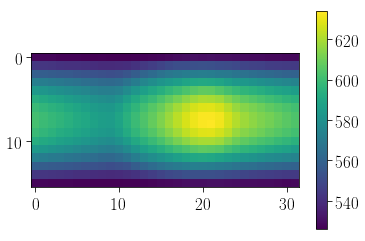

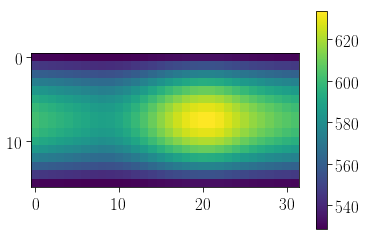

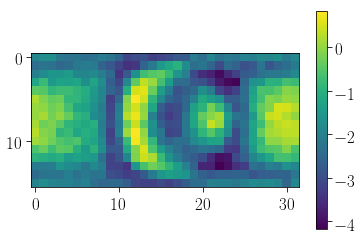

In [11]:
plt.imshow(model.predict(x_test[-1:]).reshape(planet.map.values.shape))
plt.colorbar()
plt.show()

plt.imshow(y_test[-1:].reshape(planet.map.values.shape))
plt.colorbar()
plt.show()

plt.imshow(model.predict(x_test[-1:]).reshape(planet.map.values.shape)-y_test[-1:].reshape(planet.map.values.shape))
plt.colorbar()
plt.show()

In [12]:
%timeit model.predict(x_test[-1:]).reshape(planet.map.values.shape)

1.19 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
